In [1]:
from parcels import (
    FieldSet,
    JITParticle,
    ScipyParticle,
    ParticleSet,
    AdvectionRK4,
    AdvectionRK4_3D,
    StatusCode,
)
import parcels

import datetime as dt
from datetime import datetime, timedelta

import dask
from dask.distributed import Client

import numpy as np

from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean

import xarray as xr
from glob import glob
import cartopy
import cartopy.crs as ccrs
import xoak
from time import time
import warnings

warnings.simplefilter("ignore")

In [ ]:
# Parameters
RNG_seed = 123


# Time
year = 2016
start_month = 1
end_month = 12
start_day = 1
end_day = 1
max_age_d = 200
# timedirection
timearrow = 1
# Timestep in minutes
dt_in_minutes = 15
output_dt_in_minutes = 15


# Box traits
min_depth_m = 0
max_depth_m = 25
box_side_length_km = 5

site_counter = 8

number_particles = 100

repeated_release = True
repeatdt_d = 1

isPapermill = False


In [ ]:
if not isPapermill:
    # year = 2021
    start_month = 1
    end_month = 12
    start_day = 1
    end_day = 31
    max_age_d = 200
    # timedirection
    timearrow = 1
    # Timestep in minutes
    dt_in_minutes = 60
    output_dt_in_minutes = 60

    # Box traits
    min_depth_m = 0
    max_depth_m = 25
    box_side_length_km = 5

    site_counter = 5

    number_particles = 100

    repeated_release = False
    repeatdt_d = 5

# Read Files

In [4]:
# Get Variables from Parameters
start_date = np.datetime64(f"{year}-{start_month:02d}-{start_day:02d}", "D")
end_date = np.datetime64(f"{year}-{end_month:02d}-{end_day:02d}", "D")
first_day_in_year = np.datetime64(f"{year}-01-01", "D")

start_date_str = start_date.astype(str).replace("-","")
end_date_str = end_date.astype(str).replace("-","")

start_file = (start_date - first_day_in_year).astype(int) * 4-1
end_file = (end_date - first_day_in_year + 1).astype(int) * 4+1

runtime_in_days = (end_date - start_date).tolist()
dt_min = np.timedelta64(dt_in_minutes, "m").tolist()
dt_out_min = np.timedelta64(output_dt_in_minutes, "m").tolist()

np.random.seed(RNG_seed)
save_path = f"/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/{year}/"

print(start_file,end_file)

607 617


In [5]:
# Read Files
data_path_orig_files = Path("/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/")
data_path_divz_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data/")
data_path_static_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data")
data_path_static_fine = data_path_static_files / "static_file_fine"
data_path_static_coarse = data_path_static_files / "static_file_coarse"

sigma_file_fine = data_path_static_fine / "sigma_file_fine.nc"
H0_file_fine = data_path_static_fine / "H0_file_fine.nc"
divH0_file_fine = data_path_static_fine / "divH0_file_fine.nc"
lonlat_file_fine = data_path_static_fine / "lonlat_file_fine.nc"

c_files_fine = sorted(data_path_orig_files.glob(f"c_file_fine_{year}/*"))[start_file:end_file]
z_files_fine = sorted(data_path_orig_files.glob(f"z_file_fine_{year}/*"))[start_file:end_file]
t_files_fine = sorted(data_path_orig_files.glob(f"t_file_fine_{year}/*"))[start_file:end_file]
divz_files_fine = sorted(data_path_divz_files.glob(f"divz_file_fine_{year}/*"))[start_file:end_file]

sigma_file_coarse = data_path_static_coarse / "sigma_file_coarse.nc"
H0_file_coarse = data_path_static_coarse / "H0_file_coarse.nc"
divH0_file_coarse = data_path_static_coarse / "divH0_file_coarse.nc"
lonlat_file_coarse = data_path_static_coarse / "lonlat_file_coarse.nc"

c_files_coarse = sorted(data_path_orig_files.glob(f"c_file_coarse_{year}/*"))[start_file:end_file]
z_files_coarse = sorted(data_path_orig_files.glob(f"z_file_coarse_{year}/*"))[start_file:end_file]
t_files_coarse = sorted(data_path_orig_files.glob(f"t_file_coarse_{year}/*"))[start_file:end_file]
divz_files_coarse = sorted(data_path_divz_files.glob(f"divz_file_coarse_{year}/*"))[start_file:end_file]

In [6]:
# open eta and H0 files
ds_eta_fine = xr.open_dataset(z_files_fine[0])
ds_H0_fine = xr.open_dataset(H0_file_fine)

ds_eta_coarse = xr.open_dataset(z_files_coarse[0])
ds_H0_coarse = xr.open_dataset(H0_file_coarse)

# Functions

In [7]:
# https://github.com/Yichabod/natural_disaster_pred/blob/master/cropping_coordinates.py

earth_radius = 6271.0
degrees_to_radians = np.pi / 180.0
radians_to_degrees = 180.0 / np.pi


def change_in_latitude(kms):
    "Given a distance north, return the change in latitude."
    return (kms / earth_radius) * radians_to_degrees


def change_in_longitude(latitude, kms):
    "Given a latitude and a distance west, return the change in longitude."
    # Find the radius of a circle around the earth at given latitude.
    r = earth_radius * np.cos(np.multiply(latitude, degrees_to_radians))
    return (kms / r) * radians_to_degrees

In [8]:
# Draw uniformly distributed random positions on the globe
def get_uniform_random_latlon_in(
    lat_min, lat_max,
    lon_min, lon_max,
    number_particles,
):
    lat = np.random.uniform(
        lat_min, lat_max,
        size=number_particles,
    )
    lon = np.random.uniform(
        lon_min, lon_max,
        size=number_particles,
    )
    return lat, lon

# Samples

In [9]:
suptitle_size = 20
title_size = 16
mapsize = (16, 8)
extent = (2.5, 27.5, 52, 62)
lonmid = np.mean(extent[:2])
latmid = np.mean(extent[:2])
map_projection = ccrs.Stereographic(
    central_longitude=lonmid, central_latitude=latmid,
    )
def basemap(ax):
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=["left", "bottom"], y_inline=False,)
    return ax

In [10]:
folder_path = "/gxfs_work/geomar/smomw597/2025_Fucus/output/"
sample_Points_path = Path(folder_path, "SamplePoints/SamplePoints.shp")
gdf_sample_points = gpd.read_file(sample_Points_path).set_index("Station_nu")
station = gdf_sample_points.loc[site_counter].station
lat_site = gdf_sample_points.loc[site_counter].geometry.y
lon_site = gdf_sample_points.loc[site_counter].geometry.x

In [11]:
centroid = gdf_sample_points.dissolve().centroid
release_area = gdf_sample_points.to_crs(map_projection).buffer(distance=10e3)[site_counter]

In [12]:
# Make release box
lat_release_min = lat_site - change_in_latitude(box_side_length_km / 2)
lat_release_max = lat_site + change_in_latitude(box_side_length_km / 2)
lon_release_min = lon_site - change_in_longitude(lat_site, box_side_length_km / 2)
lon_release_max = lon_site + change_in_longitude(lat_site, box_side_length_km / 2)

# Make Box around release box, to ensure that depth values are existent while establishing particles
lat_box_min = lat_site - change_in_latitude(box_side_length_km * 2)
lat_box_max = lat_site + change_in_latitude(box_side_length_km * 2)
lon_box_min = lon_site - change_in_longitude(lat_site, box_side_length_km * 2)
lon_box_max = lon_site + change_in_longitude(lat_site, box_side_length_km * 2)

In [13]:
# Build masks
fine_mask = (
    (ds_eta_fine.lat >= lat_box_min)
    & (ds_eta_fine.lat <= lat_box_max)
    & (ds_eta_fine.lon >= lon_box_min)
    & (ds_eta_fine.lon <= lon_box_max)
)
coarse_mask = (
    (ds_eta_coarse.lat >= lat_box_min)
    & (ds_eta_coarse.lat <= lat_box_max)
    & (ds_eta_coarse.lon >= lon_box_min)
    & (ds_eta_coarse.lon <= lon_box_max)
)

In [14]:
# Check if area is in fine grid or not
if fine_mask.sum() == 0:
    region_mask = coarse_mask
    elev = ds_eta_coarse.elev.isel(time=0, drop=True)
    h0 = ds_H0_coarse.H0
else:
    region_mask = fine_mask
    elev = ds_eta_fine.elev.isel(time=0, drop=True)
    h0 = ds_H0_fine.H0

# only seed in water
elev_mask = ~ elev.isnull()

# avoid weird H0 < 0 locations
h0_mask = h0 > 0

In [15]:
# Check where to place the particles horizontaly and the fraction of valid cells
seed_here = (
    (elev_mask & h0_mask)
    .where(region_mask, drop=True)
    .astype(bool)
)
fraction_valid_horizontal = seed_here.mean().data
if fraction_valid_horizontal > 0:
    number_horizontal = int(number_particles / fraction_valid_horizontal * 1.25)
    seasurface_height = (
        (elev + h0)
        .where((region_mask & h0_mask), drop=True)
    )
else:
    print("Es ist ein Fehler aufgetreten")

In [16]:
# Generate lats and lons
# uniformly distributed everywhere
# uniform in lat / lon =/= uniform in m2
release_lats = np.random.uniform(lat_release_min, lat_release_max, size=number_horizontal)
release_lons = np.random.uniform(lon_release_min, lon_release_max, size=number_horizontal)

# check validity of positions
# note that this is _not_ per water volume but per sigma!
seedable = seed_here.sel(
    lon=xr.DataArray(release_lons, dims="particle"),
    lat=xr.DataArray(release_lats, dims="particle"),
    method="nearest",
).data

# remove invalide positions and cut to legth afterwards
release_lons = release_lons[seedable][:number_particles]
release_lats = release_lats[seedable][:number_particles]
release_depth = np.zeros_like(release_lons)

# Parcels

## Custom Kernel

In [ ]:
def DeleteErrorParticle(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [19]:
CustomKernel = [AdvectionRK4, DeleteErrorParticle]

## Particles

In [21]:
dim_dict_lonlat = dict(lon="lon", lat="lat")
dim_dict_lonlat_time = dict(dim_dict_lonlat, time="time")
dim_dict_lonlat_time_depth = dict(dim_dict_lonlat_time, depth = "sigma")

In [22]:
# Prepare reading of variables
fieldset_variables = ["U", "V",]
variable_names = ["uvel", "vvel",]
dim_dicts = [dim_dict_lonlat_time, dim_dict_lonlat_time, ]
interp_methods = ["cgrid_velocity", "cgrid_velocity",]

variables = dict(zip(fieldset_variables, variable_names))
dimensions = dict(zip(fieldset_variables, dim_dicts))
interp_method = dict(zip(fieldset_variables, interp_methods))

In [ ]:
# Prepare reading of variables
fieldset_variables = [
    "U", "V", "Wz", 
    "H0", "dH0dlon", "dH0dlat",
    "eta", "detadlon", "detadlat",
]
variable_names = ["uvel", "vvel", "wvel", 
    "H0", "dH0dlon", "dH0dlat",
    "eta", "detadlon", "detadlat"
]
dim_dicts = [
    dim_dict_lonlat_time_depth, dim_dict_lonlat_time_depth, dim_dict_lonlat_time_depth,
    dim_dict_lonlat, dim_dict_lonlat, dim_dict_lonlat, 
    dim_dict_lonlat_time, dim_dict_lonlat_time, dim_dict_lonlat_time,
]
interp_methods = [
    "cgrid_velocity", "cgrid_velocity", "cgrid_velocity",
    "cgrid_tracer", "cgrid_tracer", "cgrid_tracer",
    "cgrid_velocity", "cgrid_velocity", "cgrid_velocity",
]

variables = dict(zip(fieldset_variables, variable_names))
dimensions = dict(zip(fieldset_variables, dim_dicts))
interp_method = dict(zip(fieldset_variables, interp_methods))

In [23]:
# Prepare reading of variables
variables = dict(U="uvel", V="vvel")

dimensions = dict(U=dim_dict_lonlat_time, V=dim_dict_lonlat_time,)

interp_method = dict(
    U="cgrid_velocity", V="cgrid_velocity",
)

## Fieldset

### fine fieldset

In [24]:
lonlat_dict_fine = {
    "lon": lonlat_file_fine,
    "lat": lonlat_file_fine,
}
current_dict_fine = dict(
    lonlat_dict_fine, 
    depth=sigma_file_fine,
    data=c_files_fine,
)
H0_dict_fine = dict(lonlat_dict_fine, data=H0_file_fine)
divH0_dict_fine = dict(lonlat_dict_fine, data=divH0_file_fine)
divz_dict_fine = dict(lonlat_dict_fine, data=divz_files_fine)
eta_dict_fine = dict(lonlat_dict_fine, data=z_files_fine)

In [25]:
# Build fine fieldset for all the other Values
filenames_fine = dict(V=current_dict_fine, U=current_dict_fine,)

fieldset_fine = FieldSet.from_netcdf(
    filenames=filenames_fine,
    variables=variables,
    dimensions=dimensions,
    interp_method=interp_method,
    allow_time_extrapolation=False,
    gridindexingtype="nemo",
)

### coarse fieldsets

In [27]:
lonlat_dict_coarse = dict(lon=lonlat_file_coarse, lat=lonlat_file_coarse,)

current_dict_coarse = dict(
    lonlat_dict_coarse, 
    depth=sigma_file_coarse,
    data=c_files_coarse,
)
H0_dict_coarse = dict(lonlat_dict_coarse, data=H0_file_coarse)
divH0_dict_coarse = dict(lonlat_dict_coarse, data=divH0_file_coarse)
eta_dict_coarse = dict(lonlat_dict_coarse, data=z_files_coarse)
divz_dict_coarse = dict(lonlat_dict_coarse, data=divz_files_coarse)

In [28]:
# Build coarse fieldset for all the other Values
filenames_coarse = {
    "U": current_dict_coarse,
    "V": current_dict_coarse,
}

fieldset_coarse = FieldSet.from_netcdf(
    filenames=filenames_coarse,
    variables=variables,
    dimensions=dimensions,
    interp_method=interp_method,
    allow_time_extrapolation=False,
    gridindexingtype="nemo",
)

### Nested fieldset

In [29]:
# Build Nested field from the fine and coarse fields
U = parcels.NestedField("U", [fieldset_fine.U, fieldset_coarse.U])
V = parcels.NestedField("V", [fieldset_fine.V, fieldset_coarse.V])

nested_fieldset = FieldSet(U, V)


# Create Particles

In [30]:
# Build Particle Set
start_time = np.datetime64(f'{year}-{start_month:02d}-{start_day:02d}T00:00:00')

pset = ParticleSet(
    fieldset=nested_fieldset,
    pclass=parcels.JITParticle,
    lat=release_lats,
    lon=release_lons,
    depth=release_depth,
    time=[start_time for n in range(number_particles)],
    repeatdt=timedelta(days=repeatdt_d),
)
if not repeated_release:
    pset.repeatdt = None

In [32]:
filename_time = f"{start_date_str}-{end_date_str}_dt{output_dt_in_minutes}min"
filename_position = f"{station}_d{min_depth_m}m-{max_depth_m}m"
filename = f"Nested_{filename_time}_{filename_position}_N{number_particles}_seed{RNG_seed}.zarr"
# define Output path and name
if isPapermill:
    output_filename = str("PPmill_" + filename)
else:
    output_filename = str("TEST_" + filename)

output_path = Path(save_path, output_filename)
print(f"{output_path}")

/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160601-20160602_dt60min_Fehmarn exposed_d0m-25m_N100_seed123.zarr


In [33]:
# Define Outputparameters
output_particle_file = pset.ParticleFile(
    name=output_path,
    outputdt=dt_out_min,
    chunks=(number_particles, int(24 * 60 / output_dt_in_minutes)),
)

# Execute

In [34]:
# Execute Simulation
pset.execute(
    CustomKernel,
    dt=dt_min,
    runtime=runtime_in_days,
    output_file=output_particle_file,
    verbose_progress=False,
)

INFO: Output files are stored in /gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160601-20160602_dt60min_Fehmarn exposed_d0m-25m_N100_seed123.zarr.


# Analysis

## Read files

In [ ]:
# output_path = Path(save_path)

In [49]:
ds_trajectories = xr.open_zarr(output_path).compute()
# ds_trajectories["age_day"] = (ds_trajectories.age_sec/(60*60*24)).compute()
# depth_m = ds_trajectories.eta - ds_trajectories.z * (
#     ds_trajectories.eta + ds_trajectories.h0
# )
# ds_trajectories = ds_trajectories.assign(depth=depth_m)
# ds_trajectories

In [51]:
ds_trajectories.isel(obs=0).plot.scatter(x="lon", y="lat")

## Time plots

In [ ]:
# for i in np.arange(ds_trajectories.trajectory.shape[0] / number_particles):
#     traj_i = int(i*number_particles)
#     plt.plot(
#         ds_trajectories.time.isel(trajectory=traj_i),
#         ds_trajectories.age_sec.isel(trajectory=traj_i) / 3600,
#     )
# plt.show()

In [ ]:
# ds_trajectories.age_day.plot()

## Maps

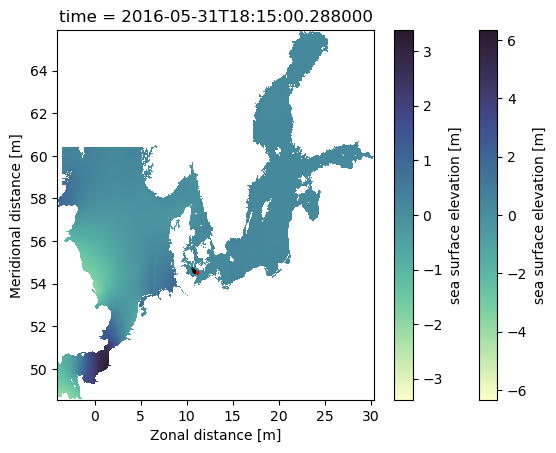

In [ ]:
# traj = ds_trajectories  # .isel(obs=671)#.isel(trajectory=6)
# # fieldset_NF
# # plt.pcolormesh(ds_eta_fine.elev.isel(time=0))
# ds_eta_fine.elev.isel(time=0).plot(
#     cmap=cmocean.cm.deep,
# )
# ds_eta_coarse.elev.isel(time=0).plot(
#     cmap=cmocean.cm.deep,
# )

# plt.scatter(
#     traj.lon,
#     traj.lat,
#     c="k",
#     s=0.00001,
# )
# plt.plot(
#     (
#         lon_release_max,
#         lon_release_max,
#         lon_release_min,
#         lon_release_min,
#         lon_release_max,
#     ),
#     (
#         lat_release_max,
#         lat_release_min,
#         lat_release_min,
#         lat_release_max,
#         lat_release_max,
#     ),
#     c="r",
# )
# # plt.xlim(7,27)
# # plt.ylim(53,60)
# plt.xlabel("Zonal distance [m]")
# plt.ylabel("Meridional distance [m]")
# plt.show()

In [53]:
last_valid_obs = ds_trajectories.obs.where(ds_trajectories.lon.notnull()).max('obs').astype(int)
last_step = ds_trajectories.isel(obs=last_valid_obs).compute()

last_lon = last_step.lon
last_lat = last_step.lat

last_step.to_dataframe().describe()

,lat,lon,obs,time,z
count,100.000000,100.000000,100.0,100,100.0
mean,54.590206,10.814048,23.0,2016-06-01 23:44:59.711999744,0.0
min,54.508607,10.524035,23.0,2016-06-01 23:44:59.712000,0.0
25%,54.523456,10.609469,23.0,2016-06-01 23:44:59.712000,0.0
50%,54.539362,10.840361,23.0,2016-06-01 23:44:59.712000,0.0
75%,54.667268,10.917926,23.0,2016-06-01 23:44:59.712000,0.0
max,54.767339,11.166650,23.0,2016-06-01 23:44:59.712000,0.0
std,0.089259,0.216672,0.0,NaN,0.0


In [54]:
last_lon.values

array([10.6502554 , 11.16664982, 10.65778864, 10.54617976, 10.74708439,
       10.65069248, 10.89416014, 10.76492834, 10.87128082, 10.86132694,
       10.60798862, 10.59548645, 10.88398964, 10.67143315, 11.16664982,
       10.86862661, 10.92533889, 10.8448237 , 11.11114981, 10.59766188,
       10.6099618 , 10.87754623, 11.16664982, 11.11114983, 10.65438481,
       10.82274903, 10.52574183, 11.11114981, 10.88195839, 10.55102295,
       10.89176319, 11.16664982, 11.1111498 , 10.63952055, 10.53437886,
       10.80549726, 10.80481229, 10.87356147, 10.86589718, 10.55151785,
       10.55189806, 10.89823868, 10.57605213, 10.8798108 , 10.69504274,
       10.89234812, 10.83589782, 10.85493415, 11.11114981, 10.61328922,
       10.55965266, 11.11114983, 10.84864873, 10.55449814, 11.16664982,
       10.73306207, 10.79917073, 10.55523665, 11.11114982, 11.16664982,
       10.84606705, 10.86327231, 11.11114984, 10.65072983, 10.53602273,
       10.55273355, 11.16664982, 10.65627512, 11.11114983, 11.11

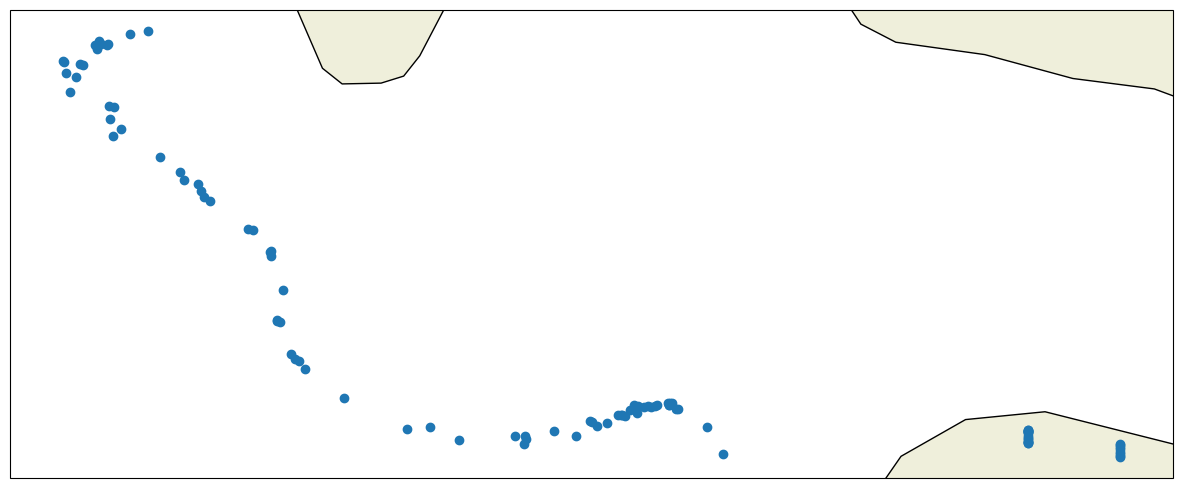

In [55]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ax.add_feature(cartopy.feature.LAND, edgecolor='k')
ax.scatter(
    last_lon,
    last_lat,
    transform=ccrs.Geodetic(),
)
plt.show()

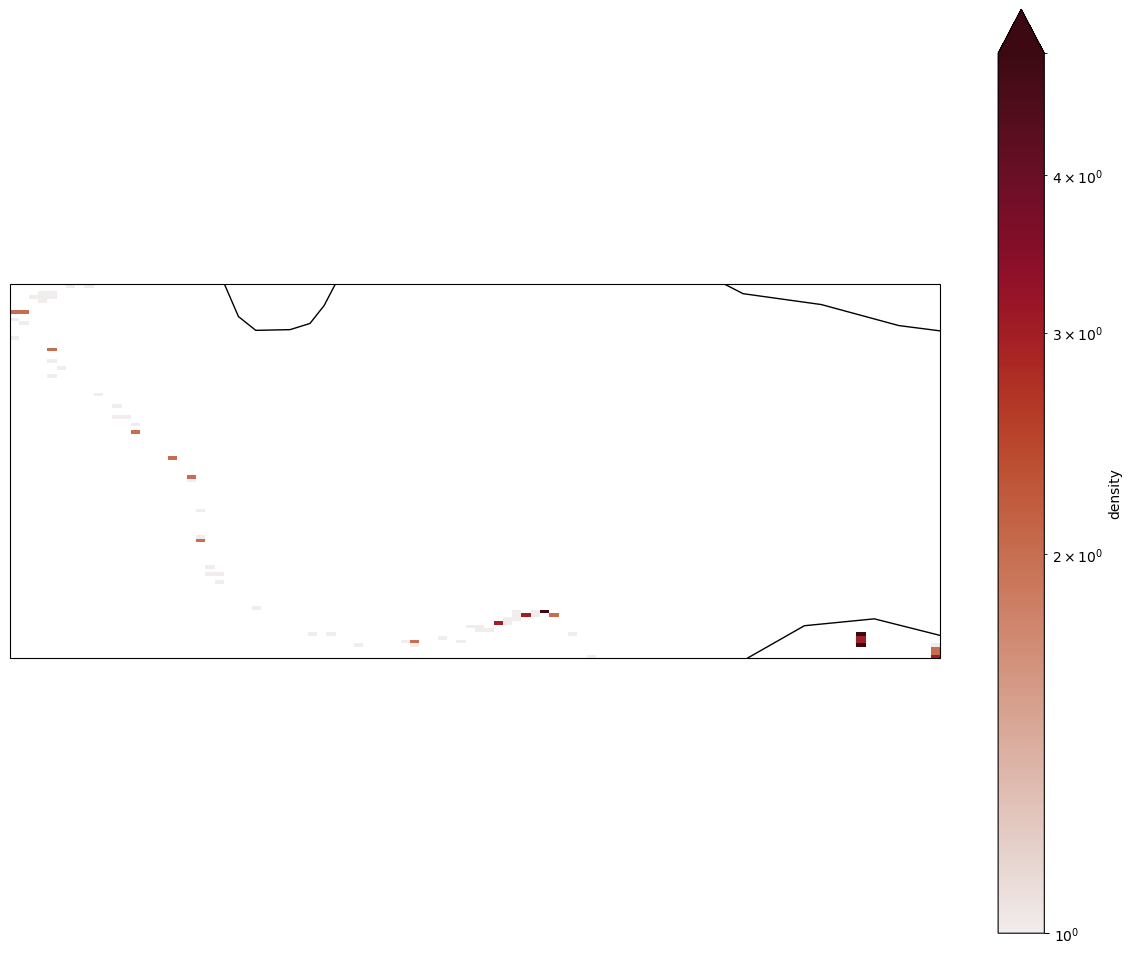

In [56]:
fig, ax = plt.subplots(
    1,1,
    subplot_kw={'projection' : ccrs.PlateCarree()},
    figsize=(15,12),
)
ax.coastlines()
dense_plt = ax.hist2d(
    last_lon,
    last_lat,
    bins=[100, 100],
    norm=mcolors.LogNorm(),
    cmap=cmocean.cm.amp,
)
fig.colorbar(
    dense_plt[3],
    ax=ax,
    extend="max",
    label="density",
)
plt.show()